# Reconstruction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.sparse.linalg import eigs

### Generate bidiagonal matrix

In [2]:
def gen_D(n):
    D = np.zeros((n-1,n))

    for i in range(n-1):
        D[i,i] = -1
        D[i,i+1] = 1

    return D

## Generate Data

In [3]:
def gen_data(xlim=1000, n_noise=350):

    x = np.linspace(0, xlim, 4*xlim)
    gen_clean = lambda x: 0.2*np.sin((np.pi/(xlim/3.5))*x)+0.4*np.sin((np.pi/(xlim/4))*x)+0.5*np.sin((np.pi/(xlim/10))*x)

    clean = gen_clean(x)

    # Number of values to add noise to
    idx = np.random.choice(len(x), n_noise, replace=False)

    # Assign into those places ramdom numbers in [-1,1)
    noisy = clean.copy()
    noisy[idx] += np.random.uniform(low=-0.25, high=0.25, size=n_noise)

    return noisy.reshape(-1, 1), clean.reshape(-1,1)


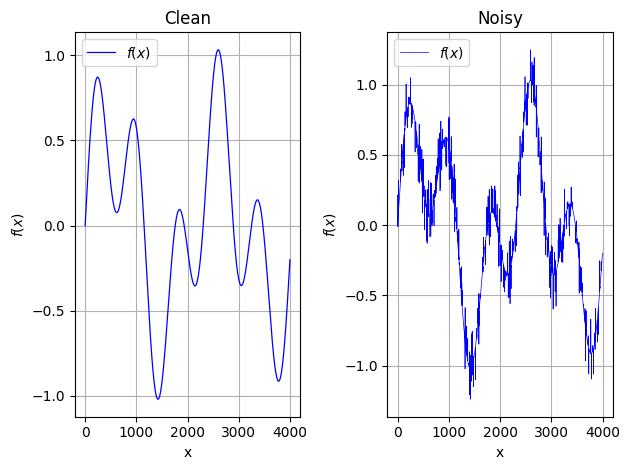

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(gen_data()[1], color="blue", label=r"$f(x)$", lw=0.9)

ax1.grid()
ax1.set(xlabel="x", ylabel=r"$f(x)$", title="Clean")
ax1.legend()


ax2.plot(gen_data()[0], color="blue", label=r"$f(x)$", lw=0.5)

ax2.set(xlabel="x", ylabel=r"$f(x)$", title="Noisy")
ax2.grid()
ax2.legend()

fig.tight_layout()

## Quadratic Smoothing

Aim is to solve $$\phi_{quad}(x)=\sum_{i=1}^{n-1}(x_{i+1}-x_{i})^{2}=\|Dx\|_{2}^{2}$$

In [5]:
def solve_quad(delta, x_cor):
    D = gen_D(len(x_cor))
    
    return np.linalg.inv(np.eye(len(x_cor))+delta*(D.T @ D)) @ x_cor.reshape(-1,1)

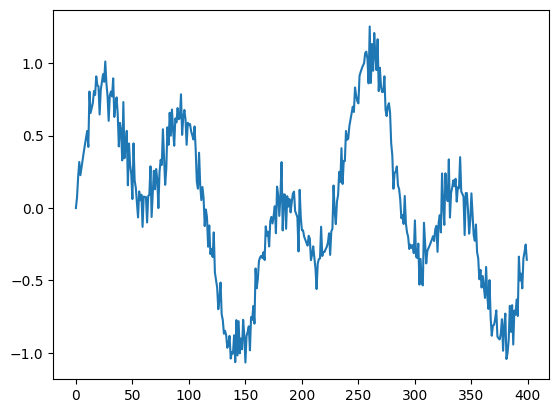

In [6]:
noisy = gen_data(xlim=100, n_noise=240)[0]
plt.plot(noisy)

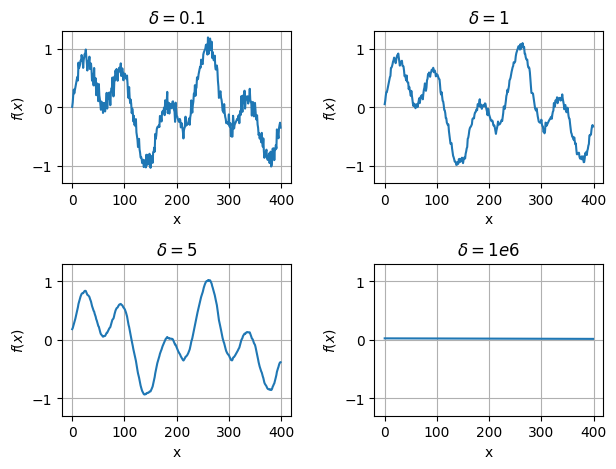

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.plot(solve_quad(0.1, noisy))
ax1.grid()
ax1.set(xlabel="x", ylabel=r"$f(x)$", title=fr"$\delta=0.1$")
ax1.set_ylim([-1.3, 1.3])

ax2.plot(solve_quad(1, noisy))
ax2.grid()
ax2.set(xlabel="x", ylabel=r"$f(x)$", title=fr"$\delta=1$")
ax2.set_ylim([-1.3, 1.3])

ax3.plot(solve_quad(10, noisy))
ax3.grid()
ax3.set(xlabel="x", ylabel=r"$f(x)$", title=fr"$\delta=5$")
ax3.set_ylim([-1.3, 1.3])

ax4.plot(solve_quad(1000000, noisy))
ax4.grid()
ax4.set(xlabel="x", ylabel=r"$f(x)$", title=fr"$\delta=1e6$")
ax4.set_ylim([-1.3, 1.3])

fig.tight_layout()

## Gradient Descent for quadratic smoothing

Assuming the gradient is given by $$\nabla_{\hat{x}}\left(\|\hat{x}-x_{\text{cor}}\|^{2}_{2}+\delta\|D\hat{x}\|^{2}_{2}\right)=2(I_{n}+\delta D^{T}D)\hat{x}-2x_{\text{cor}}$$

In [40]:
def grad_desc(x_cor, delt, lr=0.01, tol=1e-4, max_iter=1000, eps=1e-3, verbose=True):
        
        t1 = perf_counter()

        n, m = x_cor.shape
        losses = [np.inf]
        #w = np.random.uniform(-1, 1, m) # Initialise random standardized weights
        x_hat = np.zeros((n,1))
        D = gen_D(n)

        lr = 1/np.sqrt(np.linalg.eig((2*np.eye(n) + delt * (D.T @ D)).T @ (2*np.eye(n) + delt * (D.T @ D)))[0].max())
        
        for i in range(max_iter):
            #print(((np.eye(n) + delt * (D.T @ D @ x_hat)) @ x_hat))
            t3 = perf_counter()
            # Update the coefficients

            x_hat -= lr * 2 *(((np.eye(n) + delt * (D.T @ D)) @ x_hat) - x_cor)

            t4 = perf_counter()
            #print(f'Iteration {i+1} took {t4-t3:.2e} seconds. Loss = {l:.2e}')

        t2 = perf_counter()

        if verbose:
            print(f"Iterations: {i+1}")
            print(f"Smoothed: {x_hat}")
            print(f"Loss: {losses[-1]: .2f}")
            print(f"Time taken: {t2-t1: .2f} s")

        return {"optimum": x_hat, "iterations": i+1, "loss": losses[1:], "time": t2-t1}

In [55]:
x_cor, x_clean = gen_data(xlim=100, n_noise=400)

In [56]:
solved_20 = grad_desc(x_cor, 
        delt=15,
        tol=1e-6,
        max_iter=100,
        eps=1e-3,
        verbose=False)

solved_0 = grad_desc(x_cor, 
        delt=0,
        tol=1e-6,
        max_iter=100,
        eps=1e-3,
        verbose=False)

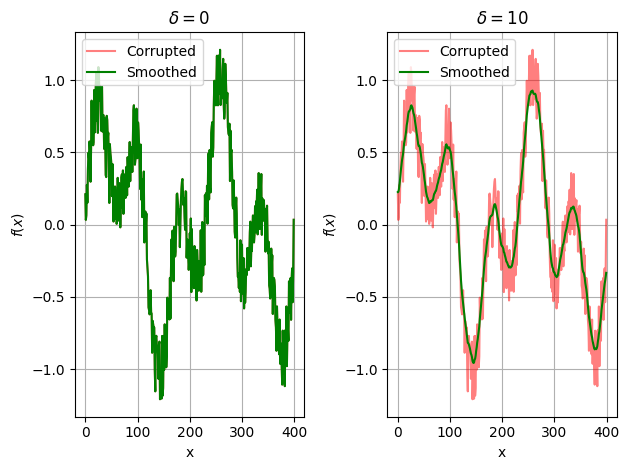

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(x_cor, label="Corrupted", color="red", alpha=.5)
ax1.plot(solved_0["optimum"], label="Smoothed", color="green")

ax1.set(xlabel="x", ylabel=r"$f(x)$", title=f"$\delta=0$")
ax1.grid()
ax1.legend()

ax2.plot(x_cor, label="Corrupted", color="red", alpha=.5)
ax2.plot(solved_20["optimum"], label="Smoothed", color="green")

ax2.grid()
ax2.set(xlabel="x", ylabel=r"$f(x)$", title=f"$\delta=10$")
ax2.legend()

fig.tight_layout()

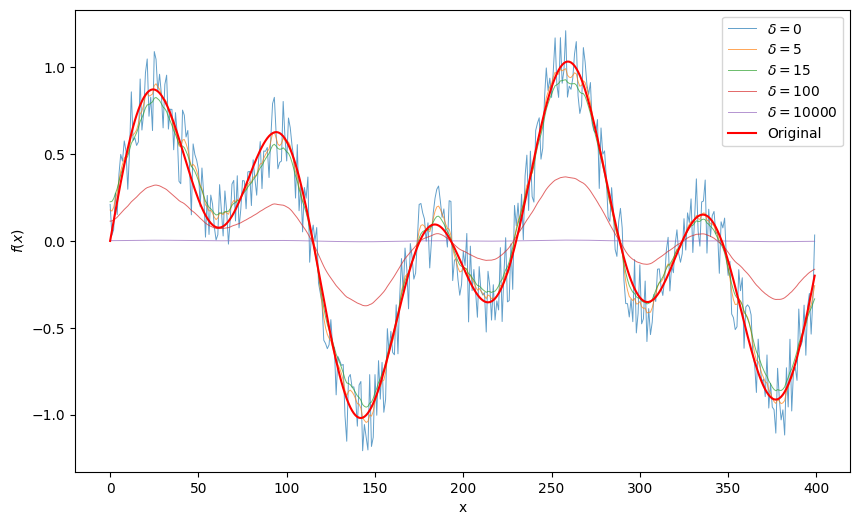

In [92]:
# fig, (ax1, ax2) = plt.subplots(1,2)

# ax1.plot(x_clean, label="Corrupted", color="red", alpha=.5)
# ax1.plot(solved_0["optimum"], label="Smoothed", color="green")

# ax1.set(xlabel="x", ylabel=r"$f(x)$", title=f"$\delta=0$")
# ax1.grid()
# ax1.legend()


deltas = [0, 5, 15, 100, 10000]

for d in deltas:
    op = grad_desc(x_cor, 
        delt=d,
        tol=1e-6,
        max_iter=100,
        eps=1e-3,
        verbose=False)["optimum"]

    plt.plot(op, label=fr"$\delta={d: .0f}$", alpha=0.7, lw=0.7)

plt.plot(x_clean, label="Original", color="red")

plt.xlabel("x"),
plt.ylabel(r"$f(x)$")
#plt.title(f"Illustration showing quadratic smoothing for various values of $\delta$ compared with the original signal")
plt.legend(loc="upper right")

plt.rcParams["figure.figsize"]= (10,6)

plt.savefig("quadratic_smooth.png", dpi=300)

In [20]:
(2*(np.eye(x_cor.shape[0]) + delt * D.T@D)).T @ (2*(np.eye(x_cor.shape[0]) + delt * D.T@D))

array([[ 244., -340.,  100., ...,    0.,    0.,    0.],
       [-340.,  684., -440., ...,    0.,    0.,    0.],
       [ 100., -440.,  684., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,  684., -440.,  100.],
       [   0.,    0.,    0., ..., -440.,  684., -340.],
       [   0.,    0.,    0., ...,  100., -340.,  244.]])

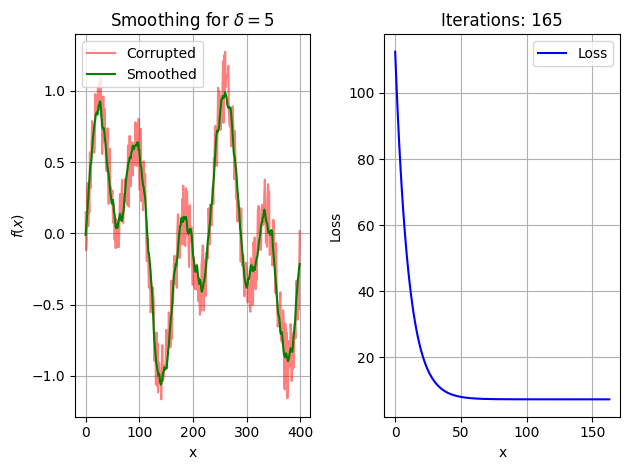

In [16]:
delt = 5
D = gen_D(x_cor.shape[0])

lr = 1 / np.real(np.max(eigs(2 * (np.eye(x_cor.shape[0]) + delt * D.T@D))[0]))

solved = grad_desc(x_cor, 
        delt=delt,
        lr=lr,
        tol=1e-6,
        max_iter=1000,
        eps=1e-3,
        verbose=False)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(noisy, label="Corrupted", color="red", alpha=.5)
ax1.plot(solved["optimum"], label="Smoothed", color="green")

ax1.grid()
ax1.set(xlabel="x", ylabel=r"$f(x)$", title=f"Smoothing for $\delta={delt}$")
ax1.legend()

ax2.plot(solved["loss"], label="Loss", color="blue")

ax2.grid()
ax2.set(xlabel="x", ylabel="Loss", title=f"Iterations: {solved['iterations']}")
ax2.legend()

fig.tight_layout()